In [207]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

senic_df = pd.read_csv('./senic_output.csv')

senic_df.head()

,infection_risk,stay_length,age,culture_ratio,chest_ratio,bed_count,med_school,available_services,region_1,region_2,region_3,region_4
0,4.1,7.13,55.7,9.0,39.6,279,2,60.0,0,0,0,1
1,1.6,8.82,58.2,3.8,51.7,80,2,40.0,0,1,0,0
2,2.7,8.34,56.9,8.1,74.0,107,2,20.0,0,0,1,0
3,5.6,8.95,53.7,18.9,122.8,147,2,40.0,0,0,0,1
4,5.7,11.20,56.5,34.5,88.9,180,2,40.0,1,0,0,0


In [208]:
senic_columns = senic_df.columns

y = 'infection_risk'
x = " + ".join([i for i in senic_columns if  i != y])

In [209]:
fit = ols(y + '~' + x, 
            data=senic_df).fit()

print(fit.summary())

senic_df['resids'] = fit.resid
senic_df['sq_resids'] = fit.resid**2
stud_res = fit.outlier_test()
senic_df['studentized_resids'] = stud_res['student_resid']
senic_df['yhat'] = fit.predict()


                            OLS Regression Results                            
Dep. Variable:         infection_risk   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     13.69
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           5.52e-15
Time:                        23:17:33   Log-Likelihood:                -144.90
No. Observations:                 113   AIC:                             311.8
Df Residuals:                     102   BIC:                             341.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.9385      1

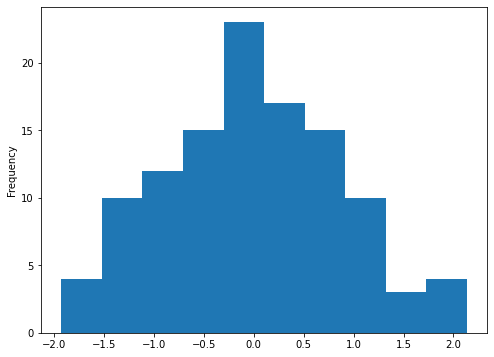

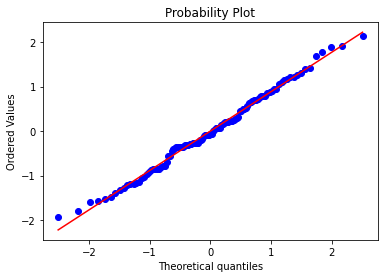

Shapiro Statistic: 0.991
Data appears to be normal with p-value: 0.645


In [210]:


def residual_plots(x, y, xlabel, ylabel, loess=True, frac=0.5):

#     plt.scatter(x, y)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    if loess == True:
        sm_x, sm_y = sm_lowess(y, x,  frac=frac, 
                               it=2, return_sorted = True).T
        plt.plot(sm_x, sm_y, color='tomato')
        plt.plot(x, y, 'k.')
    
    
    
def normality_output(data):
    shapiro_output = stats.shapiro(data)
    shapiro_stat = shapiro_output[0]
    shapiro_p = shapiro_output[1]
    print("Shapiro Statistic: {:.3f}".format(shapiro_stat))
    if shapiro_p < 0.05:
        print('Data is non-normal with p-value: {:.5f}'.format(shapiro_p))
    else:
        print('Data appears to be normal with p-value: {:.3f}'.format(shapiro_p))
        
        
    return shapiro_output

### Test normality of residuals!

plt.figure(figsize=(8, 6))

senic_df['resids'].plot(kind='hist');

fig = plt.figure()
ax1 = fig.add_subplot(111)
prob = stats.probplot(senic_df['resids'], dist=stats.norm, plot=ax1)
plt.show();

shapiro_stats = normality_output(senic_df['resids'])




## Raw Residual Plots

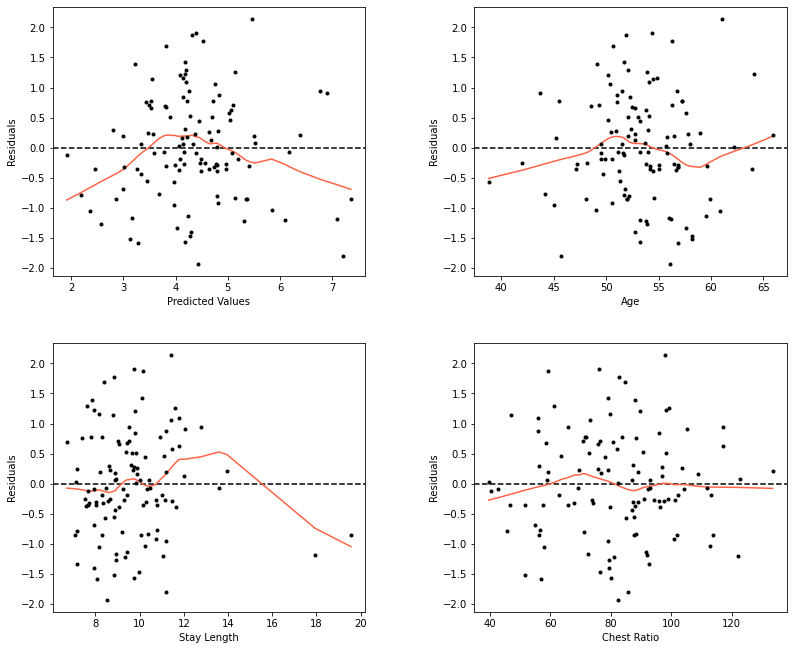

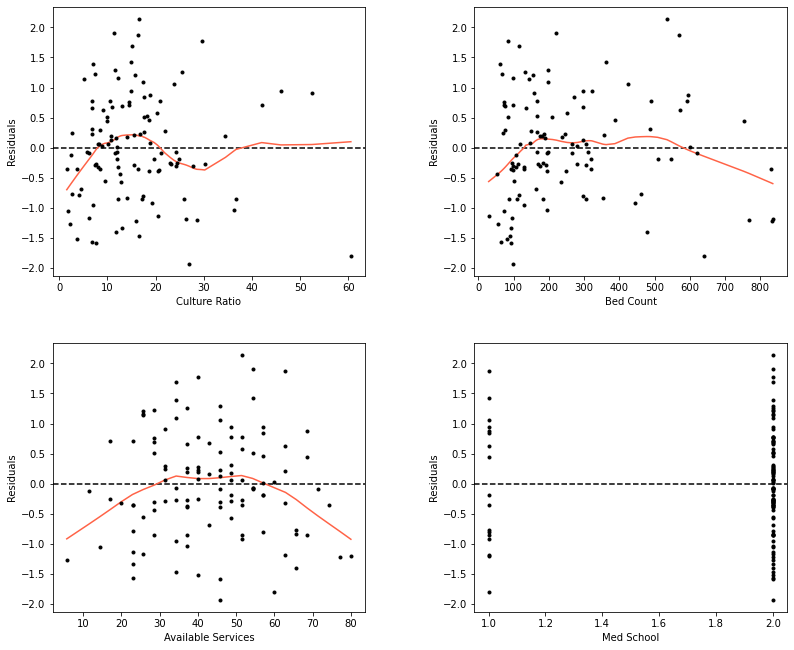

In [213]:
plt.figure(figsize=(12, 10))


plt.subplot(221)
residual_plots(senic_df['yhat'], senic_df['resids'], 'Predicted Values', 'Residuals')
plt.subplot(222)
residual_plots(senic_df['age'], senic_df['resids'], 'Age', 'Residuals')
plt.subplot(223)
residual_plots(senic_df['stay_length'], senic_df['resids'], 'Stay Length', 'Residuals')
plt.subplot(224)
residual_plots(senic_df['chest_ratio'], senic_df['resids'], 'Chest Ratio', 'Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

plt.figure(figsize=(12, 10))

plt.subplot(221)
residual_plots(senic_df['culture_ratio'], senic_df['resids'], 'Culture Ratio', 'Residuals')
plt.subplot(222)
residual_plots(senic_df['bed_count'], senic_df['resids'], 'Bed Count', 'Residuals')
plt.subplot(223)
residual_plots(senic_df['available_services'], senic_df['resids'], 'Available Services', 'Residuals')
plt.subplot(224)
residual_plots(senic_df['med_school'], senic_df['resids'], 'Med School', 'Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Squared Residuals

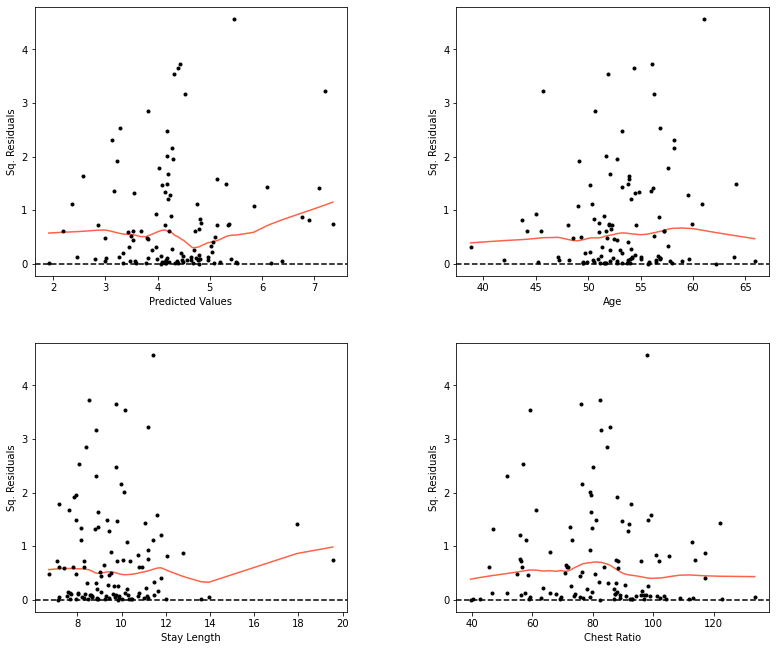

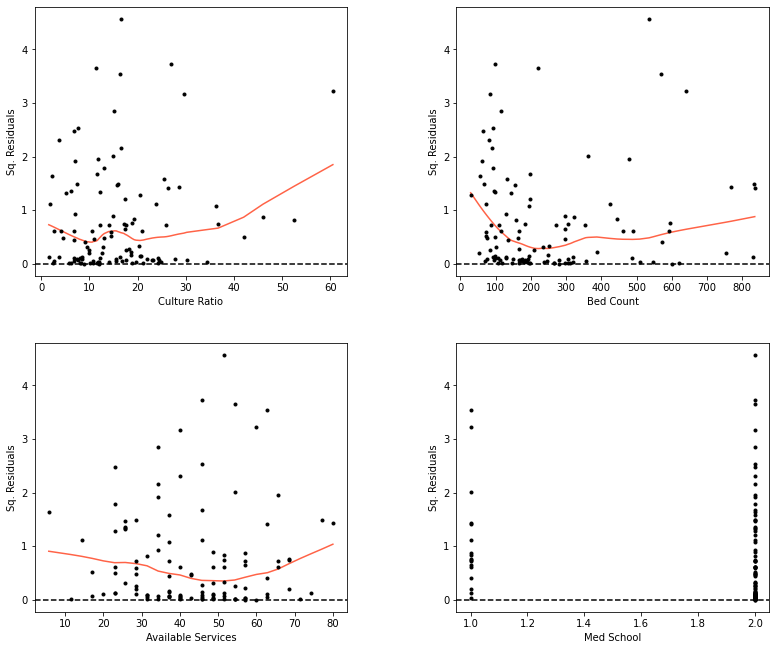

In [215]:
plt.figure(figsize=(12, 10))


plt.subplot(221)
residual_plots(senic_df['yhat'], senic_df['sq_resids'], 'Predicted Values', 'Sq. Residuals')
plt.subplot(222)
residual_plots(senic_df['age'], senic_df['sq_resids'], 'Age', 'Sq. Residuals')
plt.subplot(223)
residual_plots(senic_df['stay_length'], senic_df['sq_resids'], 'Stay Length', 'Sq. Residuals')
plt.subplot(224)
residual_plots(senic_df['chest_ratio'], senic_df['sq_resids'], 'Chest Ratio', 'Sq. Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

plt.figure(figsize=(12, 10))

plt.subplot(221)
residual_plots(senic_df['culture_ratio'], senic_df['sq_resids'], 'Culture Ratio', 'Sq. Residuals')
plt.subplot(222)
residual_plots(senic_df['bed_count'], senic_df['sq_resids'], 'Bed Count', 'Sq. Residuals')
plt.subplot(223)
residual_plots(senic_df['available_services'], senic_df['sq_resids'], 'Available Services', 'Sq. Residuals')
plt.subplot(224)
residual_plots(senic_df['med_school'], senic_df['sq_resids'], 'Med School', 'Sq. Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Studentized Residuals

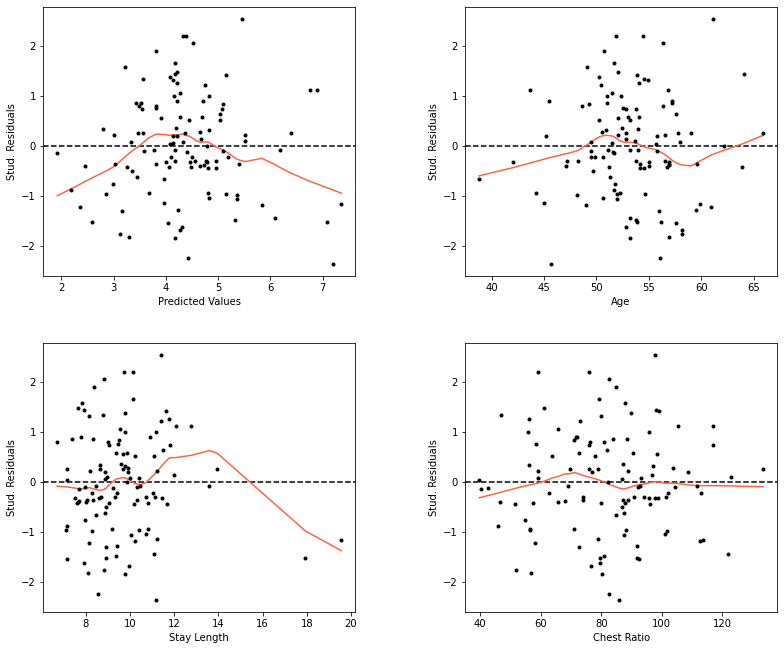

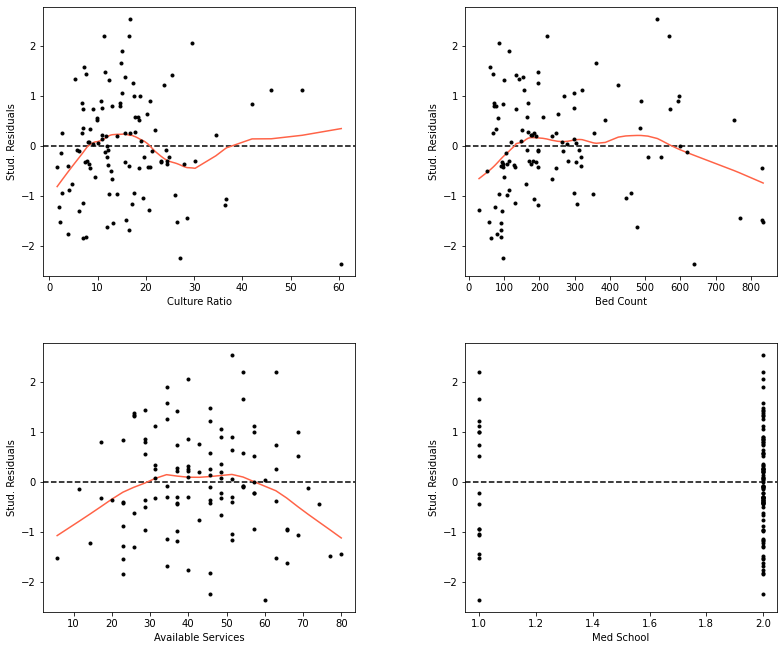

In [216]:
plt.figure(figsize=(12, 10))


plt.subplot(221)
residual_plots(senic_df['yhat'], senic_df['studentized_resids'], 'Predicted Values', 'Stud. Residuals')
plt.subplot(222)
residual_plots(senic_df['age'], senic_df['studentized_resids'], 'Age', 'Stud. Residuals')
plt.subplot(223)
residual_plots(senic_df['stay_length'], senic_df['studentized_resids'], 'Stay Length', 'Stud. Residuals')
plt.subplot(224)
residual_plots(senic_df['chest_ratio'], senic_df['studentized_resids'], 'Chest Ratio', 'Stud. Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

plt.figure(figsize=(12, 10))

plt.subplot(221)
residual_plots(senic_df['culture_ratio'], senic_df['studentized_resids'], 'Culture Ratio', 'Stud. Residuals')
plt.subplot(222)
residual_plots(senic_df['bed_count'], senic_df['studentized_resids'], 'Bed Count', 'Stud. Residuals')
plt.subplot(223)
residual_plots(senic_df['available_services'], senic_df['studentized_resids'], 'Available Services', 'Stud. Residuals')
plt.subplot(224)
residual_plots(senic_df['med_school'], senic_df['studentized_resids'], 'Med School', 'Stud. Residuals')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

## Residual analysis

Some definite bowing of residuals 

## Breusch Pagan

Null Hypothesis: Homoscedasticity is present
Alternative Hypothesis: Homoscedasticity is not present

Because p > 0.05 we fail to reject the null hypothesis and conclude there is not enough evidence that heteroscadacity is present


In [185]:
#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(fit.resid, fit.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 12.143375654836113),
 ('p-value', 0.35296323944882946),
 ('f-value', 1.2281040782748303),
 ('f p-value', 0.2822345075568254)]